# Setup

## Imports and Installs

### Installs
No need to install OSMPythonTools as it is no longer used.

In [ ]:
!pip install geopandas
!pip install geojson
!pip install overpass
!pip install alphashape

  Preparing metadata (setup.py) ... done
  Created wheel for osm2geojson: filename=osm2geojson-0.2.5-py3-none-any.whl size=13950 sha256=7f175d0f452e23ca27510faee5590daa283b00aad2a6e2085200463ddbef8472
  Stored in directory: /root/.cache/pip/wheels/44/9d/4c/a859e0f56957a67bf06c3a5a14899205c3b1864471fcc3c2cc
Successfully built osm2geojson
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.7/703.7 kB 32.5 MB/s eta 0:00:00


### Imports

In [ ]:
import pandas as pd
import json
import geojson
#https://github.com/mvexel/overpass-api-python-wrapper/blob/main/README.md
import overpass
#https://pypi.org/project/osm2geojson/
import csv
import os
import logging
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from shapely.geometry import Point, Polygon
import requests
import time
from google.colab import drive
import sys
import ast
from alphashape import alphashape
import geopandas as gpd
import os
from collections import defaultdict
import os.path
from tqdm import tqdm

## Parameters

#### Selecting City and State

In [ ]:
#State name to be taken for input later
#state_name = input()
state_name = "New York"


#City name to be taken for later input
#city_name = input()
city_name = "City of New York"

## Image Utilities Setup

In [ ]:
# Default size of images
size = (16,16)

# Function to check for img directory and save image
def save_image(plot, img_name: str):
  try:
    os.mkdir(data_dir + "/Images")
  except:
    print(data_dir + "/Images" + " Already Exists")

  try:
    os.mkdir(f'{data_dir}/Images/Data-{min_children}-{superspot_hotspot_ratio}')
  except:
    print(f'{data_dir}/Images/Data-{min_children}-{superspot_hotspot_ratio}', "Already Exists")

  plot.savefig(f'{data_dir}/Images/Data-{min_children}-{superspot_hotspot_ratio}/{img_name}.png')

## Connecting to Drive

We first mount the drive. This step requires permission to be given. Running the cell should open a permission page to allow colab access to google drive.

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Setting the file directory to the data folder. All files will be referenced to this working directory.

Folder structure:

```
📁Drive/
└─ 📁<personal_dir>/
   ├─ 📁<city_name_1> - RL Delivery Data/
   ├─ 📁<city_name_2> - RL Delivery Data/
   └─ 📁Raw GeoJsons/
```


In [ ]:
# Your personal folder to STORE THE FOLDER THAT WILL STORE DATA goes here
personal_dir = "./gdrive/MyDrive/DeliverAI Data Folder/"

# personal_dir = "./gdrive/MyDrive/Thesis/Source Code & Supporting Files/City Data"  # Example personal folder for Robert, assuming "City Data" folder is created in drive

mini = False
data_dir = f"{personal_dir}{city_name}_mini - RL Delivery Data" if mini else f"{personal_dir}{city_name} - RL Delivery Data"

try:
  os.mkdir(data_dir)
except:
  print(data_dir + " Already Exists")

# See directory content
data = os.listdir(data_dir)
print("Files in directory : ", data)


./gdrive/MyDrive/DeliverAI Data Folder/City of New York - RL Delivery Data Already Exists
Files in directory :  ['Original Location Data', 'Processed Location Data', 'Census Data', 'Images', 'Hotspot Data', 'avg_hotspot_data.json']


In [ ]:
# Columbus
census_tract_subset = ['39049001300', '39049001400', '39049002000', '39049002510', '39049002520', '39049007830', '39049002100', '39049001000', '39049001810', '39049001902', '39049002800', '39049003200', '39049003600', '39049008500', '39049001110', '39049001200', '39049001500', '39049001700', '39049001820', '39049002200', '39049002300', '39049001901' '39049001122', '39049003000', '39049002900', '39049001600', '39049001121', '39049001901']

# Philadelphia
# census_tract_subset = ['42101008802', '42101008702', '42101008701', '42101008602', '42101008601', '42101008500', '42101008000', '42101007900', '42101009400', '42101009300', '42101009200', '42101010400', '42101010300', '42101010500', '42101010200', '42101008400', '42101007200', '42101008102', '42101008101', '42101007800', '42101007700', '42101007300', '42101011100', '42101011200', '42101019500', '42101011800', '42101011300', '42101010700', '42101010600', '42101011900']

# Getting Consumer and Producer data


Using OSM, we can query locations that are suited for our study. We need those locations which can either provide food or act as a potential drop location for a customer. Thse locations can be queried using Overpass API that uses the OSM data. While it is possible to use the OSMPythonTools for queries the data uses python scripts, it is easier to query and visualise data from Overpass Turbo and directly download the data from the site in the `.geojson` format. The latter was used for this notebook but now they are directly gotten using Overpass API. These data files are stored in `Original Data` folder.

### Getting the Pickup and Drop points

In [ ]:
#Overpass API example Query - NOTE approaches used through overpass turbo may not work directly through overpass API due to overpass turbo
#allowing additional query struture for ease of use. This can be overcome by taking a query crafted using overpass Turbo and going to
#Export > Query > Standalone Query > download/copy to get the actual query that overpass turbo sends to the overpass API

"""  OLD VERSION OF QUERY
[out:json][timeout:900];
// fetch area “chicago” to search in
area[name="Chicago"]->.searchArea;
(
  way["building"="dormitory"](area.searchArea);
  //relation["building"="dormitory"](area.searchArea);

);
out body;
>;
out skel qt;
"""

# Admin levels: 2: country, 4: state, 8: cities
"""  NEW VERSION OF QUERY
[out:json][timeout:900];

area[name="United States"]["admin_level"="2"]->.country;
area[name="Ohio"]["admin_level"="4"]->.state;
area[name="Oxford"]->.city;

way["building"="dormitory"](area.country)(area.state)(area.city);

out body;
>;
out skel qt;
"""

'  NEW VERSION OF QUERY\n[out:json][timeout:900];\n\narea[name="United States"]["admin_level"="2"]->.country;\narea[name="Ohio"]["admin_level"="4"]->.state;\narea[name="Oxford"]->.city;\n\nway["building"="dormitory"](area.country)(area.state)(area.city);\n\nout body;\n>;\nout skel qt;\n'

Creates a query from given attributes

In [ ]:
# Timeout increased from 25 to 900

def buildQuery(stateName, cityName, category, tag):
  return f"""
          [out:json][timeout:900];
          area[name=\"United States\"][\"admin_level\"=\"2\"]->.country;
          area[name=\"{stateName}\"][\"admin_level\"=\"4\"]->.state;
          area[name=\"{cityName}\"]->.city;
          (
            way[\"{category}\"=\"{tag}\"](area.country)(area.state)(area.city);
          );
          out body;
          >;
          out skel qt;
          """

# Test print to make sure it works
#print(buildQuery(state_name, city_name, "building", "dormitory"))

In [ ]:
#Converts the raw osm data into a geojson object, this object needs to be in the same form that the original data gathered @
# https://overpass-turbo.eu/ is in. More information about the geojson can be found in the help section of overpass turbo.


def overpass_to_geojson(overpass_data):
    node_dict = {node['id']: node for node in overpass_data['elements'] if node['type'] == 'node'}
    features = []
    for element in overpass_data['elements']:
        if element['type'] == 'way' and 'tags' in element and ('building' in element['tags'] or 'building:part' in element['tags']):
            coordinates = [[node_dict[node_id]['lon'], node_dict[node_id]['lat']] for node_id in element['nodes']]
            # Ensure the polygon is closed by repeating the first coordinate at the end
            if coordinates[0] != coordinates[-1]:
                coordinates.append(coordinates[0])
            geometry = {'type': 'Polygon', 'coordinates': [coordinates]}
            properties = {'@id': f"way/{element['id']}", **element['tags']}  # Include tags directly within properties
            feature = {'type': 'Feature', 'id': f"way/{element['id']}", 'properties': properties, 'geometry': geometry}  # Include 'id' here
            features.append(feature)
    feature_collection = {
        'type': 'FeatureCollection',
        'features': features,
        'generator': 'overpass-turbo',  # Added generator field
        'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.',  # Added copyright field
        'timestamp': '2024-06-02T00:20:11Z'  # Added timestamp field
    }
    return feature_collection


In [ ]:
def save_data(query, fileName):
  query_sub = query[query.index("("):]
  print("Query: " + query_sub[7:query_sub.index("]")+1])

  # Create an Overpass API object
  api = overpass.API(timeout=900)

  #This took hours to find out, if build is not set to false by default it tries to add its own "[out:json];" and "out body;" at the begining and end
  result = api.get(query, build=False)
  print("Result done.")


  if(fileName in pickLocations):
    modifier = "Original Location Data/Pickup Point Data"
  else:
    modifier = "Original Location Data/Drop Point Data"


  data = overpass_to_geojson(result)
  print("Count:", len(data['features']))


  with open(data_dir + "/" + modifier + "/" + fileName, 'w') as f:
    json.dump(data, f, indent=2)
  print("Dumped.", end="\n------\n")


In [ ]:
fileNames = ["restaurant_raw_data.geojson","cafe_raw_data.geojson","apartments_raw_data.geojson","residential_raw_data.geojson","fast_food_raw_data.geojson","food_court_raw_data.geojson","college_raw_data.geojson","university_raw_data.geojson","dormitory_raw_data.geojson","hospital_raw_data.geojson","detached_raw_data.geojson","hotel_raw_data.geojson","house_raw_data.geojson","office_raw_data.geojson","community_centre_raw_data.geojson","bakery_raw_data.geojson","supermarket_raw_data.geojson"]
pickLocations = ["supermarket_raw_data.geojson","restaurant_raw_data.geojson","cafe_raw_data.geojson","fast_food_raw_data.geojson","food_court_raw_data.geojson","bakery_raw_data.geojson"]
dropLocations = ["apartments_raw_data.geojson","residential_raw_data.geojson","college_raw_data.geojson","university_raw_data.geojson","dormitory_raw_data.geojson","hospital_raw_data.geojson","detached_raw_data.geojson","hotel_raw_data.geojson","house_raw_data.geojson","office_raw_data.geojson","community_centre_raw_data.geojson"]


try:
  os.mkdir(data_dir + "/" + "Original Location Data")
except:
  print(data_dir + "/" + "Original Location Data" + " Already Exists")

try:
  os.mkdir(data_dir + "/" + "Original Location Data/Pickup Point Data")
except:
  print(data_dir + "/" + "Original Location Data/Pickup Point Data" + " Already Exists")

try:
  os.mkdir(data_dir + "/" + "Original Location Data/Drop Point Data")
except:
  print(data_dir + "/" + "Original Location Data/Drop Point Data" + " Already Exists")

try:
  os.mkdir(data_dir + "/" + "Processed Location Data")
except:
  print(data_dir + "/" + "Processed Location Data" + " Already Exists")

try:
  os.mkdir(data_dir + "/" + "Processed Location Data/Pickup Point Data")
except:
  print(data_dir + "/" + "Processed Location Data/Pickup Point Data" + " Already Exists")

try:
  os.mkdir(data_dir + "/" + "Processed Location Data/Drop Point Data")
except:
  print(data_dir + "/" + "Processed Location Data/Drop Point Data" + " Already Exists")


consumer_producer_data_exists = True

for fName in pickLocations:
  if (not os.path.isfile(data_dir + "/Original Location Data/Pickup Point Data/" + fName)):
    consumer_producer_data_exists = False


for fName in pickLocations:
  if (not os.path.isfile(data_dir + "/Original Location Data/Drop Point Data/" + fName)):
    consumer_producer_data_exists = False


if(consumer_producer_data_exists == False or re_gen):


  queries = [
    buildQuery(state_name, city_name, "amenity", "restaurant"),
    buildQuery(state_name, city_name, "amenity", "cafe"),
    buildQuery(state_name, city_name, "building", "apartments"),
    buildQuery(state_name, city_name, "building", "residential"),
    buildQuery(state_name, city_name, "amenity", "fast_food"),
    buildQuery(state_name, city_name, "amenity", "food_court"),
    buildQuery(state_name, city_name, "building", "college"),
    buildQuery(state_name, city_name, "building", "university"),
    buildQuery(state_name, city_name, "building", "dormitory"),
    buildQuery(state_name, city_name, "building", "hospital"),
    buildQuery(state_name, city_name, "building", "detached"),
    buildQuery(state_name, city_name, "building", "hotel"),
    buildQuery(state_name, city_name, "building", "house"),
    buildQuery(state_name, city_name, "building", "office"),
    buildQuery(state_name, city_name, "amenity", "community_centre"),
    buildQuery(state_name, city_name, "shop", "bakery"),
    buildQuery(state_name, city_name, "shop", "supermarket")
  ]

  i = 0
  for query in queries:
    save_data(query, fileNames[i])
    i = i + 1
else:
  print("Consumer/Producer Data already exists.")  # TODO CHANGE LATER

./gdrive/MyDrive/DeliverAI Data Folder/City of New York - RL Delivery Data/Original Location Data Already Exists
./gdrive/MyDrive/DeliverAI Data Folder/City of New York - RL Delivery Data/Original Location Data/Pickup Point Data Already Exists
./gdrive/MyDrive/DeliverAI Data Folder/City of New York - RL Delivery Data/Original Location Data/Drop Point Data Already Exists
./gdrive/MyDrive/DeliverAI Data Folder/City of New York - RL Delivery Data/Processed Location Data Already Exists
./gdrive/MyDrive/DeliverAI Data Folder/City of New York - RL Delivery Data/Processed Location Data/Pickup Point Data Already Exists
./gdrive/MyDrive/DeliverAI Data Folder/City of New York - RL Delivery Data/Processed Location Data/Drop Point Data Already Exists
Query:        way["amenity"="restaurant"]
Result done.
Count: 284
Dumped.
------
Query:        way["amenity"="cafe"]
Result done.
Count: 63
Dumped.
------
Query:        way["building"="apartments"]
Result done.
Count: 22988
Dumped.
------
Query:      

#Creating the GeoJSON


Geojson provides easy and effecient to handle geo data. It has only one main requirement - every data frame element needs to have an attribute that contains geometry objects. Usually it is named as `geometry` or needs to be specified seperately if the name is different.

### Drop Unneccsary Attributes
First drop unnecessary attributes. The Census Tract data contains many attributes that are not necessary for our analysis. We drop these columns to avoid storing excess data and taking extra time for computing queries. This becomes specially important when we have to perform joins among data frames.

In [ ]:
#Edited to allow for generic city use

"""
INSERT CHECK FOR data_dir + "/Census Data/RAW_census_tract_data.geojson"
"""


# census_dir = data_dir + "/Census Data/RAW GeoJsons/" + state_name + ".geojson"

# IMPORTANT: I store the GeoJsons in one folder outside of the data directory of individual cities so that I only need to have it once. The original line of code is above.
census_dir = personal_dir + "Raw GeoJsons/" + state_name + ".geojson"
census_df = gpd.read_file(census_dir)

#All attributes of a geojson converted from census.gov shapefiles using ogr2ogr
#keeping GEOID as it represents a unique identifier for each census tract. It is a combination of the census ID which is only unqiue within
#a county, county ID which is only unique within a state, and the state ID. This makes a fully unique idetifier that is 11 digits long.
census_df = census_df.drop('STATEFP', axis=1)
census_df = census_df.drop('COUNTYFP', axis=1)
census_df = census_df.drop('TRACTCE', axis=1)
census_df = census_df.drop('AFFGEOID', axis=1)
# census_df = census_df.drop('GEOID', axis=1)
census_df = census_df.drop('NAME', axis=1)
census_df = census_df.drop('LSAD', axis=1)
census_df = census_df.drop('ALAND', axis=1)
census_df = census_df.drop('AWATER', axis=1)



try:
  os.mkdir(data_dir + "/Census Data/")
except:
  print(data_dir + "/Census Data/" + " Already Exists")


In [ ]:
census_df['GEOID'] = census_df['GEOID'].astype(str)
census_df = census_df[census_df['GEOID'].isin(census_tract_subset)] if mini else census_df
census_df.to_file(data_dir + "/Census Data/RAW_census_tract_data.geojson", driver="GeoJSON")

Like MySQL, GeoPandas also provides join operations on data frames using the geometry attribute. Doing a left-join on the locations and census tracts assigns every selected location to a census tract.
Also after joining the 2 data frames, uneccessary attributes from the OSM data are dropped. This significantly reduced file size (by almost 10 times in most cases!)
<br>
<br>
*IMPORTANT NOTE*
<br>
Since we are no longer using the old way of having way and node files for each data location the old named files must no longer be in the folder as the drop files will still have the same name overwriting them but the pick files will have different names than the original processed output causing the original Chicago pickup locations to show up unless the original pickup files are removed.

### Adding Tract ID to Consumer/Producer Data

In [ ]:
census_dir = data_dir + "/Census Data/RAW_census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

# loading directotry of raw pickup locations
pick_data_dir = data_dir + "/Original Location Data/Pickup Point Data/"
pick_files = os.listdir(pick_data_dir)
print(pick_files)
for file_name in pick_files:
  file_dir = pick_data_dir + file_name
  file_df = gpd.read_file(file_dir)


  # edited to make generic crs match
  file_df = file_df.to_crs(census_df.crs)
  #####

  join_left_df = file_df.sjoin(census_df, how="left")
  join_left_df = join_left_df.dropna(subset=['GEOID'])


  for column in join_left_df.columns.tolist():
    if (column not in ["@id", "name", "geometry", "amenity", "building", "shop", "GEOID"]):
      join_left_df = join_left_df.drop(column, axis=1)

  # making file name for storing lat long of all locations
  new_file_dir = data_dir + "/Processed Location Data/Pickup Point Data/" + file_name
  new_file_dir = new_file_dir[:-16]
  new_file_dir += "location_data.geojson"

  join_left_df.to_file(new_file_dir, driver="GeoJSON")

['restaurant_raw_data.geojson', 'cafe_raw_data.geojson', 'fast_food_raw_data.geojson', 'food_court_raw_data.geojson', 'bakery_raw_data.geojson', 'supermarket_raw_data.geojson']


In [ ]:
census_dir = data_dir + "/Census Data/RAW_census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

# loading directotry of raw drop locations
drop_data_dir = data_dir + "/Original Location Data/Drop Point Data/"
drop_files = os.listdir(drop_data_dir)
print(drop_files)
for file_name in drop_files:
  file_dir = drop_data_dir + file_name
  file_df = gpd.read_file(file_dir)

  # edited to make generic crs match
  file_df = file_df.to_crs(census_df.crs)
  #####


  join_left_df = file_df.sjoin(census_df, how="left")
  join_left_df = join_left_df.dropna(subset=['GEOID'])


  for column in join_left_df.columns.tolist():
    if (column not in ["@id", "name", "geometry", "amenity", "building", "shop", "GEOID"]):
      join_left_df = join_left_df.drop(column, axis=1)

  # making file name for storing lat long of all locations
  new_file_dir = data_dir + "/Processed Location Data/Drop Point Data/" + file_name
  new_file_dir = new_file_dir[:-16]
  new_file_dir += "location_data.geojson"

  join_left_df.to_file(new_file_dir, driver="GeoJSON")

['apartments_raw_data.geojson', 'residential_raw_data.geojson', 'college_raw_data.geojson', 'university_raw_data.geojson', 'dormitory_raw_data.geojson', 'hospital_raw_data.geojson', 'detached_raw_data.geojson', 'hotel_raw_data.geojson', 'house_raw_data.geojson', 'office_raw_data.geojson', 'community_centre_raw_data.geojson']


### Find tracts with producers and consumers
These two sections are to get the tracts that have data points within them. This will help to remove all tracts which have no pickup or drop points within them so that they may be discarded to allow for faster data processing.

In [ ]:
#Stores all census tract id's that are used
pick_tracts = set()

pick_data_dir = data_dir + "/Processed Location Data/Pickup Point Data/"
pick_files = os.listdir(pick_data_dir)
print("Files for Pickup Points Data: ",pick_files)

for file_name in pick_files:
  file_dir = pick_data_dir + file_name

  with open(file_dir, 'r') as f:
    data = json.load(f)["features"]

    for element in data:

      properties = element["properties"]
      ID = properties["GEOID"]

      #Used later for tracking which census tracts have points within them to remove tracts without any data points
      pick_tracts.add(ID)

Files for Pickup Points Data:  ['restaurant_location_data.geojson', 'cafe_location_data.geojson', 'fast_food_location_data.geojson', 'food_court_location_data.geojson', 'bakery_location_data.geojson', 'supermarket_location_data.geojson']


In [ ]:
drop_tracts = set()

drop_data_dir = data_dir + "/Processed Location Data/Drop Point Data/"
drop_files = os.listdir(drop_data_dir)
print("Files for Drop Points Data: ",drop_files)

for file_name in drop_files:
  file_dir = drop_data_dir + file_name

  with open(file_dir, 'r') as f:
    data = json.load(f)["features"]

    for element in data:
      properties = element["properties"]
      ID = properties["GEOID"]

      #Used later for tracking which census tracts have points within them to remove tracts without any data points
      drop_tracts.add(ID)

Files for Drop Points Data:  ['apartments_location_data.geojson', 'residential_location_data.geojson', 'college_location_data.geojson', 'university_location_data.geojson', 'dormitory_location_data.geojson', 'hospital_location_data.geojson', 'detached_location_data.geojson', 'hotel_location_data.geojson', 'house_location_data.geojson', 'office_location_data.geojson', 'community_centre_location_data.geojson']


### Select tracts with producers and consumers and surrounded tracts
This section finally removes all non used census tracts from the census file to reduce its size to just the city that we are focused on.

In [ ]:
# If you want to skip Convex Hull step, run this code block...
census_dir = data_dir + "/Census Data/RAW_census_tract_data.geojson"
census_df = gpd.read_file(census_dir)
census_df.to_file(data_dir + "/Census Data/census_tract_data.geojson", driver="GeoJSON")

<ipython-input-27-dc80c894c43c>:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  selected_gdf['centroid'] = selected_gdf.geometry.centroid
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-27-dc80c894c43c>:45: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  surrounded_tracts = gpd.sjoin(census_df, gpd.GeoDataFrame(geometry=[

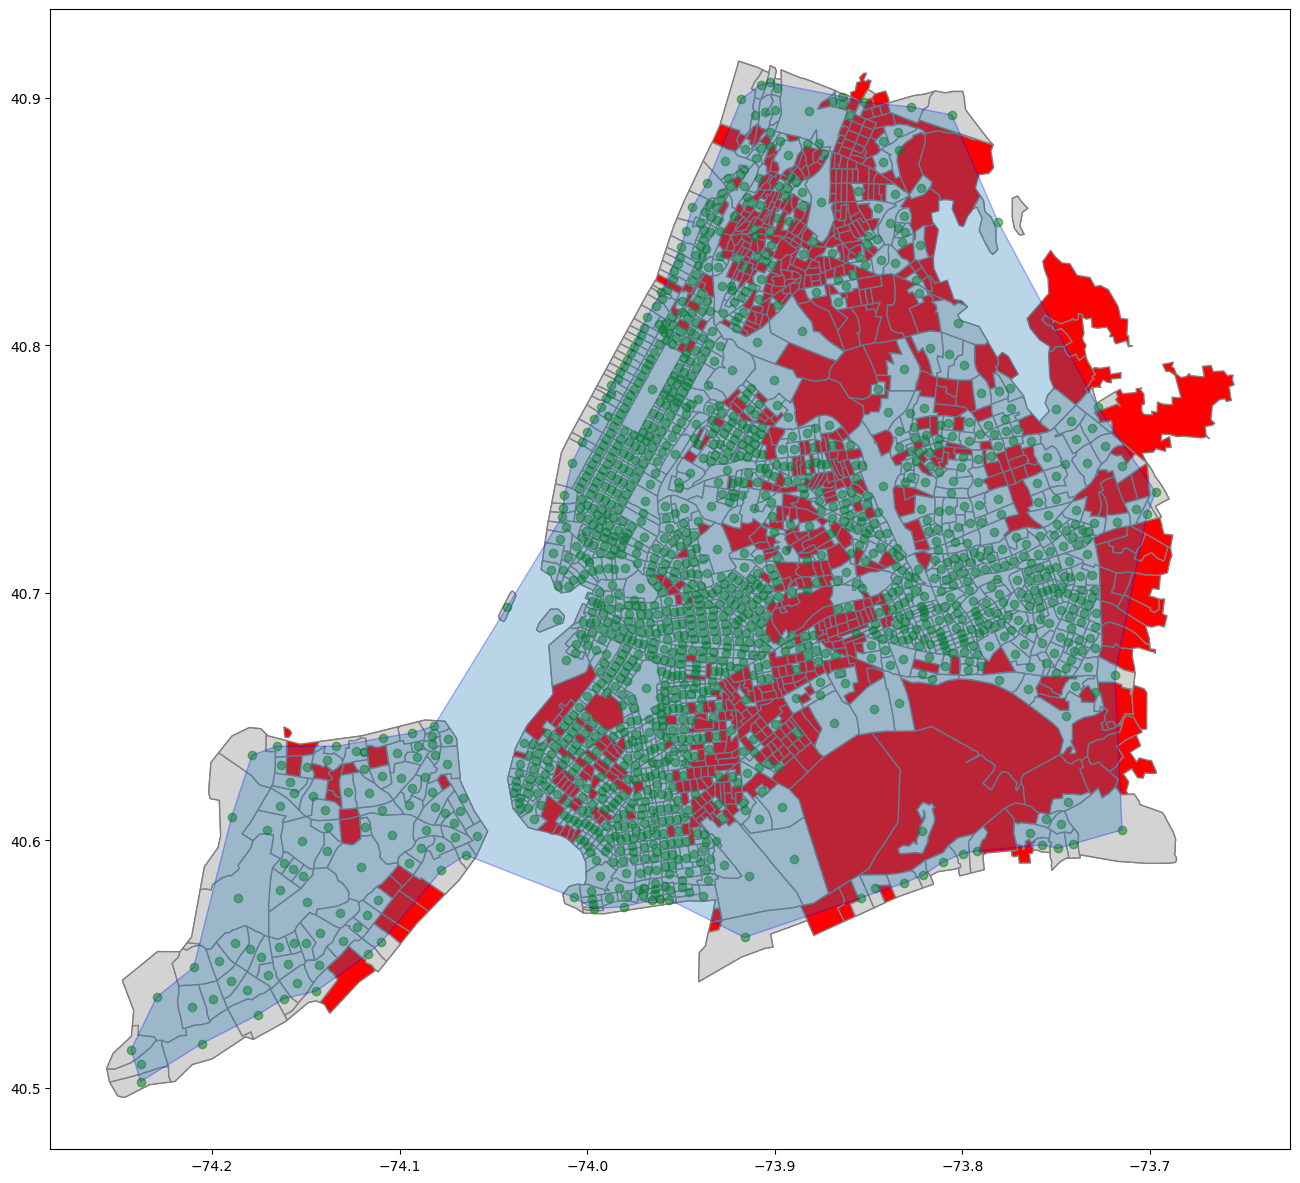

In [ ]:
from shapely.geometry import MultiPoint, Polygon, LineString
from scipy.spatial import ConvexHull
import numpy as np

census_dir = data_dir + "/Census Data/RAW_census_tract_data.geojson"
census_df = gpd.read_file(census_dir)

tracts = pick_tracts
for tract in drop_tracts:
  tracts.add(tract)


selected_gdf = census_df[census_df['GEOID'].isin(tracts)]
selected_gdf.to_file(data_dir + "/Census Data/TEST_sel.geojson", driver="GeoJSON")

non_selected_gdf = census_df[~census_df['GEOID'].isin(tracts)]
non_selected_gdf.to_file(data_dir + "/Census Data/TEST_nonsel.geojson", driver="GeoJSON")


# Check and fix invalid geometries
if not selected_gdf.is_valid.all():
    selected_gdf = selected_gdf[selected_gdf.is_valid]
if not non_selected_gdf.is_valid.all():
    non_selected_gdf = non_selected_gdf[non_selected_gdf.is_valid]


# Find the centroid point of each tract
selected_gdf['centroid'] = selected_gdf.geometry.centroid

# Extract the centroid coordinates as a list of tuples
centroid_coords = [(point.x, point.y) for point in selected_gdf['centroid']]

# Calculate the concave hull (alpha shape) with a custom alpha value
alpha_value = 50 # Adjust the alpha value as needed

for alpha in range (1, 20):
    concave_hull = alphashape(centroid_coords, alpha=alpha)
    if (type(concave_hull) != Polygon):
      continue
    alpha_value = alpha



concave_hull = alphashape(centroid_coords, alpha=alpha_value)
surrounded_tracts = gpd.sjoin(census_df, gpd.GeoDataFrame(geometry=[concave_hull]), predicate='intersects')


# Plotting
fig, ax = plt.subplots(figsize=size)

surrounded_tracts.plot(ax=ax, color='red', edgecolor='grey')
selected_gdf.plot(ax=ax, color='lightgrey', edgecolor='grey')
ax.scatter(selected_gdf['centroid'].x, selected_gdf['centroid'].y, color='green', alpha=0.5)
ax.fill(*zip(*concave_hull.exterior.coords), alpha=0.3, edgecolor='blue')
save_image(plt, 'city_removed_tracts')
plt.show()



selected_gdf = pd.concat([selected_gdf, surrounded_tracts])
census_df = census_df[census_df['GEOID'].isin(selected_gdf['GEOID'])]


census_df.to_file(data_dir + "/Census Data/census_tract_data.geojson", driver="GeoJSON")